In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [2]:
from pathlib import Path
import pickle

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import cf_xarray as cfxr
import cmocean

from lmrecon.io import open_mfdataset
from lmrecon.util import stack_state, unstack_state, to_math_order, to_cf_order
from lmrecon.lim import LIM
from lmrecon.util import get_data_path
from lmrecon.time import use_tuple_time_coords
from lmrecon.mapper import PhysicalSpaceForecastSpaceMapper, AutoencoderSpaceMapper
from lmrecon.plotting import plot_field, add_subplot_headers, get_field_label, format_plot
from lmrecon.logger import logging_disabled
from lmrecon.stats import area_weighted_mean

In [3]:
ds = xr.open_zarr("/home/enkf6/dstiller/lmrecon/cmip6/MRI-ESM2-0/past1000/seasonal_averages.zarr")#.isel(time=slice(100))
# ds = xr.open_zarr("/home/enkf6/dstiller/lmrecon/cmip6/MPI-ESM1-2-LR/past2k/seasonal_averages.zarr").isel(time=slice(100))
ds

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 3999, lat: 90, lon: 180)
Coordinates:
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) float64 32kB 850.3 850.5 850.8 ... 1.85e+03 1.85e+03
Data variables:
    cldhigh  (time, lat, lon) float32 259MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>
    cldlow   (time, lat, lon) float32 259MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>
    clwvi    (time, lat, lon) float32 259MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>
    ohc700   (time, lat, lon) float32 259MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>
    psl      (time, lat, lon) float32 259MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>
    rlut     (time, lat, lon) float32 259MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>
    rsut     (time, lat, lon) float32 259MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>
    siconc   (time, lat, lon) float32 259MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>
    tas      (time, lat, lon) float32 259MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>
    tos      (time, lat, lon) float32 259MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>
    zg500    (time, lat, lon) float32 259MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>
    zos      (time, lat, lon) float32 259MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>

In [160]:
from lmrecon.time import Season, add_season_coords
ds = add_season_coords(ds)

climatology = ds.groupby("season").mean("time").compute()
ds_anom = (ds.groupby("season") - climatology).chunk(chunks=dict(time=20))

In [164]:
ds_detrend, detrend = detrend_dataset(ds_anom, return_detrend=True)

In [170]:
np.sum(np.isnan(detrend.coeffs))

19312

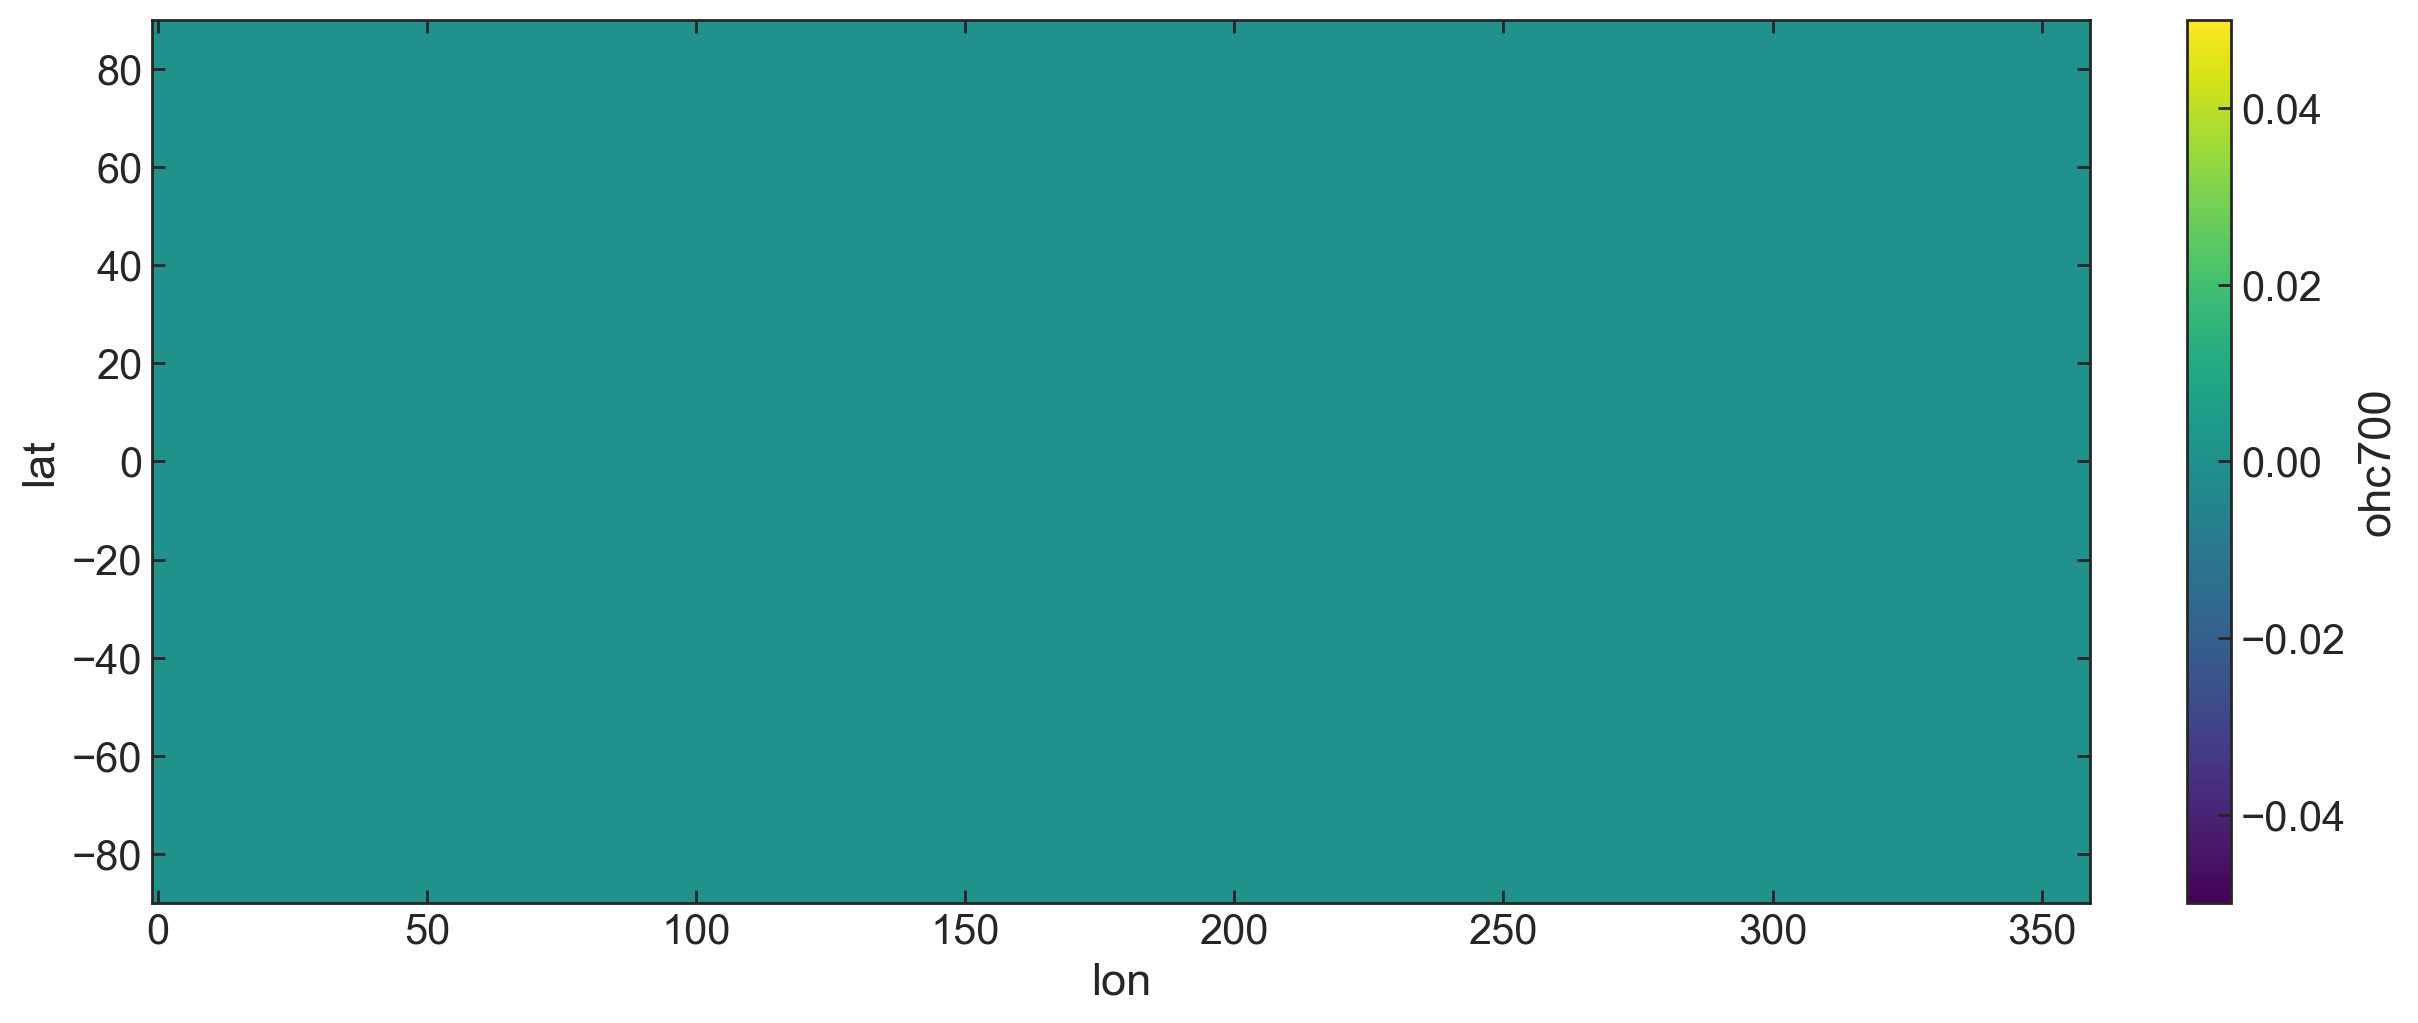

In [7]:
np.isnan(ds["ohc700"]).any("time").plot()

In [174]:
np.isnan(ds_detrend["tos"].isel(time=0).compute()).any()

<xarray.DataArray 'tos' ()> Size: 1B
array(True)
Coordinates:
    time     float64 8B 1.292
    season   object 8B Season.MAM

In [13]:
def fit_mapper_and_lim(fields, standardize_by_season):
    # Individual EOFs
    k = 20
    l = 0
    k_direct = {
        "tas": 20,
        # "tos": 20,
        # "rsut": 20,
        # "rlut": 20,
        # "ohc700": 20
    }

    mapper = PhysicalSpaceForecastSpaceMapper(
        k,
        l,
        k_direct,
        standardize_by_season=standardize_by_season
    )
    with logging_disabled():
        da_training = mapper.fit_and_forward(to_math_order(stack_state(ds[fields])))
    return da_training.compute()
    # Trigger computation
    mapper = pickle.loads(pickle.dumps(mapper))
    

    lim = LIM()
    lim.fit(to_math_order(da_training))

    return mapper, lim

# mapper = fit_mapper_and_lim(["tas", "tos", "rsut", "rlut", "ohc700"], False)
ds = fit_mapper_and_lim(["tas"], False)
ds

<xarray.DataArray '' (state: 20, time: 80)> Size: 13kB
array([[ 9.94587617e-01,  1.00019145e+00,  1.00458472e+00, ...,
         1.00124998e+00,  1.00663517e+00,  1.00014827e+00],
       [ 2.16857063e-02,  2.38312934e-03, -2.20101979e-02, ...,
         1.72779774e-03, -2.20282633e-02, -3.04787894e-03],
       [ 1.01470315e-03, -5.19014477e-03, -2.64622676e-04, ...,
        -5.07411403e-03,  3.25567716e-04,  5.16845378e-03],
       ...,
       [-8.11629176e-05,  4.28680738e-05,  2.00263804e-04, ...,
        -8.53398175e-06, -1.97818559e-04, -1.08670396e-04],
       [ 2.46062327e-05,  5.16149570e-05,  6.68619647e-05, ...,
         1.12898075e-04, -1.94312317e-04, -7.69420570e-05],
       [ 1.59457067e-05, -5.07603030e-05,  6.92633439e-05, ...,
        -7.09960709e-05,  6.94797024e-05, -5.43990411e-05]])
Coordinates:
  * time     (time) float64 640B 1.831e+03 1.831e+03 ... 1.851e+03 1.851e+03
  * state    (state) int64 160B 0 1 2 3 4 5 6 7 8 ... 11 12 13 14 15 16 17 18 19

In [12]:
mapper.mean("time")

<xarray.DataArray '' (state: 100)> Size: 800B
array([9.99858994e-01, 6.66103514e-05, 2.94798432e-06, 5.08210407e-08,
       5.51994812e-07, 2.18786455e-07, 6.20705598e-08, 6.70375842e-08,
       2.98151381e-09, 1.13312788e-07, 2.81226835e-08, 8.76902051e-09,
       8.06210960e-08, 1.56545486e-08, 1.37920247e-08, 1.45153015e-08,
       1.31923555e-08, 1.26022588e-08, 7.92171665e-09, 8.42782074e-10,
       9.99983149e-01, 5.04307305e-06, 2.77867072e-07, 1.39561303e-07,
       1.08105475e-07, 6.09162299e-08, 1.15223200e-07, 1.35898330e-08,
       1.04259530e-09, 5.56739445e-09, 3.55153218e-09, 3.11390716e-09,
       3.32517615e-09, 1.01819214e-09, 8.41744544e-10, 1.85502189e-09,
       9.89603383e-10, 2.28676638e-10, 2.68137086e-10, 3.34246316e-10,
       9.26322088e-01, 1.01865156e-02, 3.51230683e-04, 6.17161288e-04,
       1.55194298e-04, 1.59708565e-04, 5.65583615e-06, 3.85353170e-06,
       2.15908786e-05, 1.58954852e-05, 1.53716347e-05, 1.13725771e-05,
       4.19722783e-06, 1.68966811e-06, 5.86249863e-06, 2.96553253e-06,
       3.92201016e-06, 4.36463583e-06, 5.05355692e-06, 3.96424134e-06,
       9.98157683e-01, 3.57635652e-04, 1.29709952e-05, 1.58104825e-05,
       1.17173615e-05, 7.16587063e-07, 9.14879030e-06, 4.68766626e-06,
       6.29721134e-07, 3.95210870e-06, 6.08392290e-06, 1.26491304e-06,
       3.34427706e-06, 7.87855768e-07, 3.94193422e-07, 1.04479147e-07,
       3.91459655e-06, 7.51871735e-07, 3.38309572e-06, 3.00723656e-06,
       9.99999709e-01, 2.74028836e-08, 4.43622250e-08, 2.05384139e-09,
       6.72906133e-09, 5.84427500e-11, 7.06661336e-11, 4.62959043e-10,
       4.36924327e-11, 1.36341736e-10, 1.55025109e-10, 2.85951465e-11,
       8.78637649e-11, 7.57772216e-11, 3.76612914e-11, 1.84346881e-11,
       9.08960113e-11, 6.35143701e-12, 1.01206061e-11, 1.71986437e-11])
Coordinates:
  * state    (state) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99

In [8]:
mappers_leave_one_out = {}
for leaveout in ["tos", "rsut", "rlut"]:
    fields = ["tas", "tos", "rsut", "rlut"]
    fields.remove(leaveout)
    mappers_leave_one_out[leaveout] = fit_joint_eof(fields)

In [9]:
def calculate_tas_variance_remaining(ds, mapper):
    return (mapper.truncate_dataset(ds)["tas"].var("time").sum() / ds["tas"].var("time").sum()).compute().item() * 100

In [10]:
print("ind", calculate_tas_variance_remaining(ds, mapper_ind))
print("all", calculate_tas_variance_remaining(ds, mapper_joint_all))
for leaveout in mappers_leave_one_out.keys():
    print("leave out", leaveout, calculate_tas_variance_remaining(ds, mappers_leave_one_out[leaveout]))

TypeError: PhysicalSpaceForecastSpaceMapper._backward_stepwise() missing 1 required positional argument: 'data_xr'

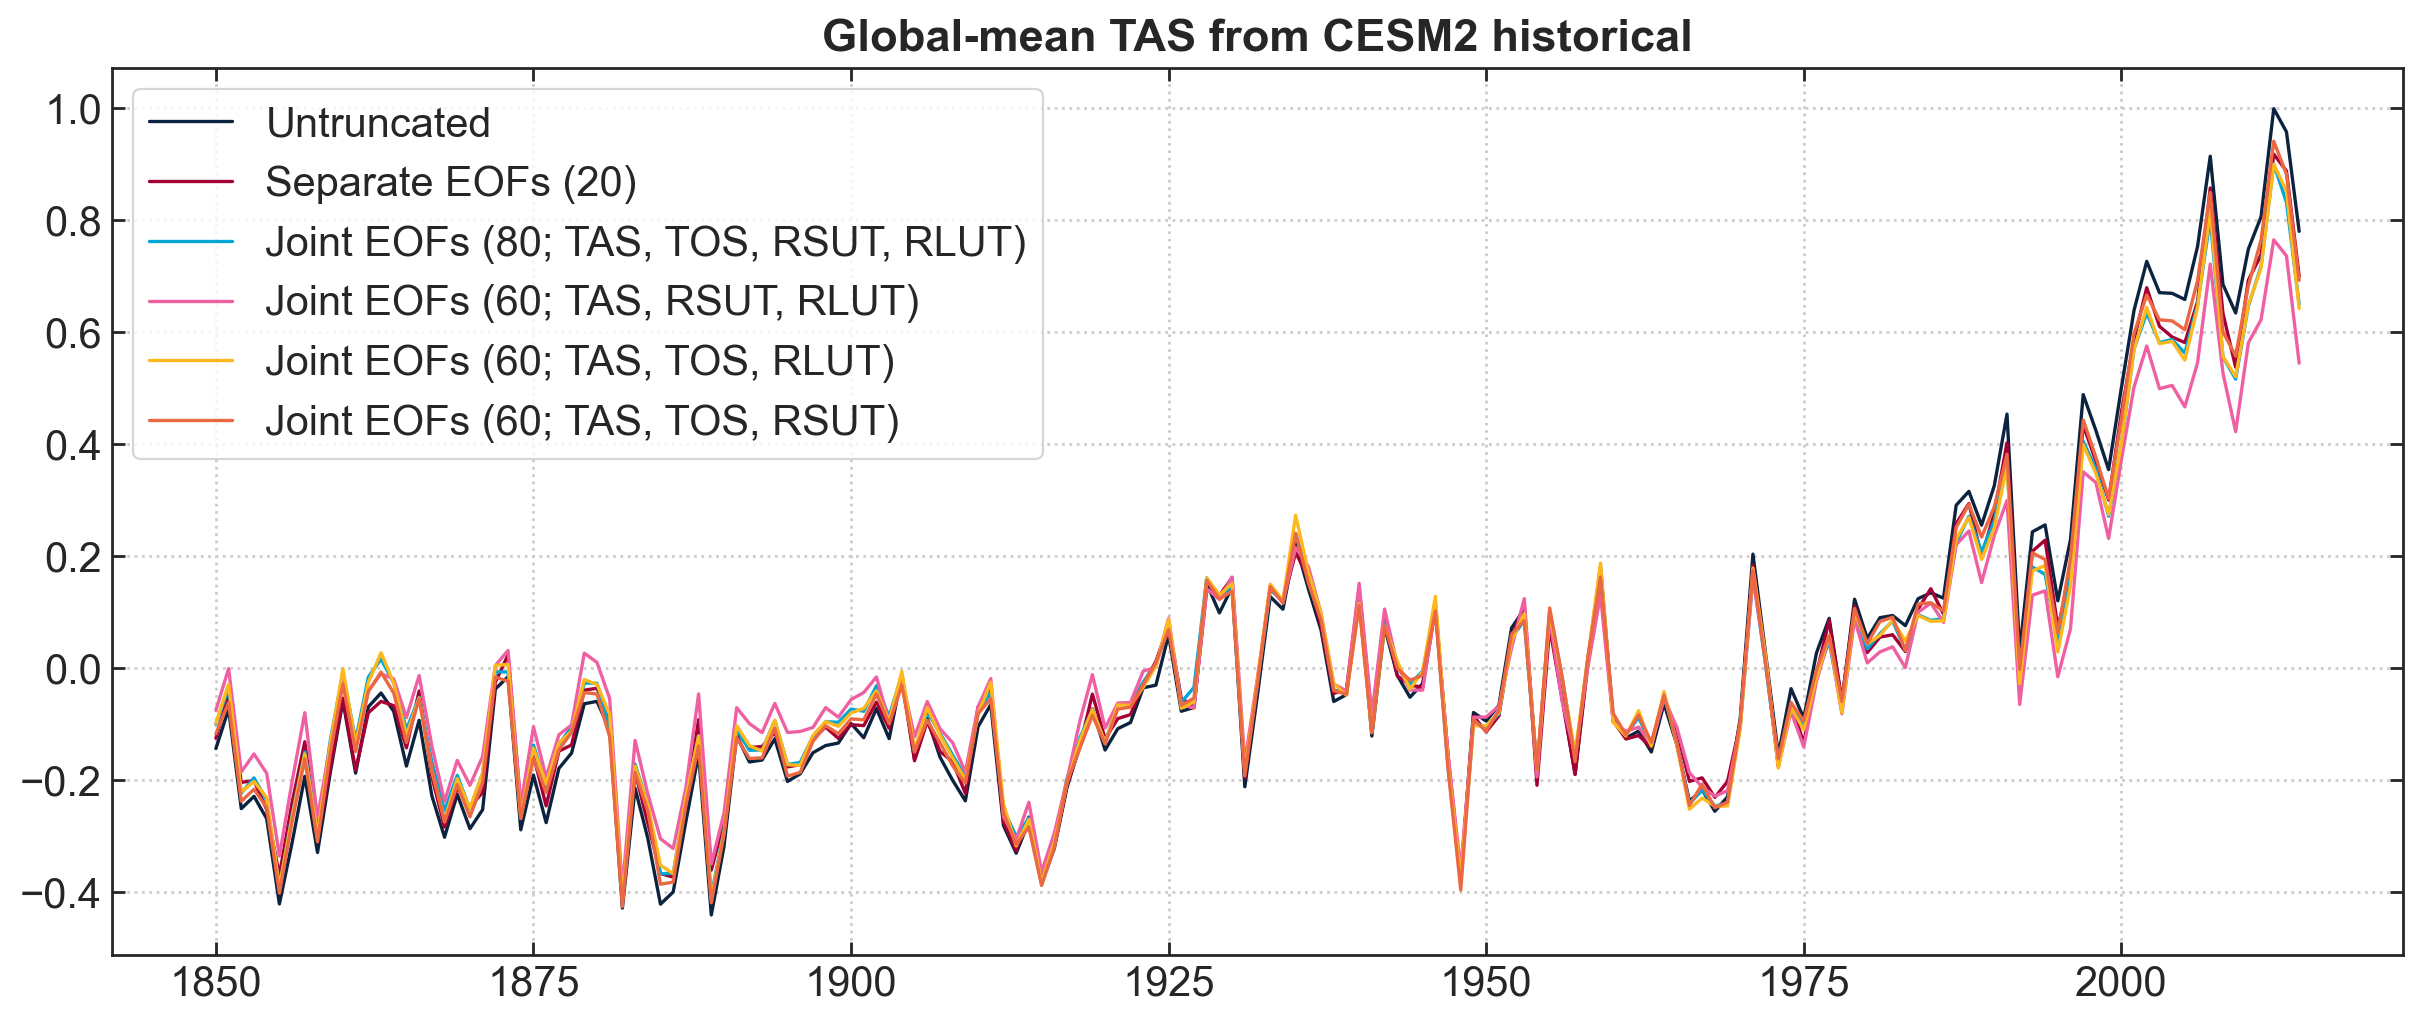

In [120]:
def plot_truncated_tas(ds, title):
    fig, ax = plt.subplots()

    ax.set_title(f"Global-mean TAS from {title}")
    
    ax.plot(ds.time, area_weighted_mean(ds)["tas"], label="Untruncated")
    ax.plot(ds.time, area_weighted_mean(mapper_ind.truncate_dataset(ds))["tas"], label="Separate EOFs (20)")
    ax.plot(ds.time, area_weighted_mean(mapper_joint_all.truncate_dataset(ds))["tas"], label="Joint EOFs (80; TAS, TOS, RSUT, RLUT)")
    for leaveout in mappers_leave_one_out.keys():
        ax.plot(ds.time, area_weighted_mean(mappers_leave_one_out[leaveout].truncate_dataset(ds)["tas"]),
                label=f"Joint EOFs (60; {', '.join(map(str.upper, mappers_leave_one_out[leaveout].fields))})")

    ax.legend()
    format_plot(major_grid=True)

# plot_truncated_tas(ds_gistemp, "GISTEMP")
plot_truncated_tas(ds_hist, "CESM2 historical")

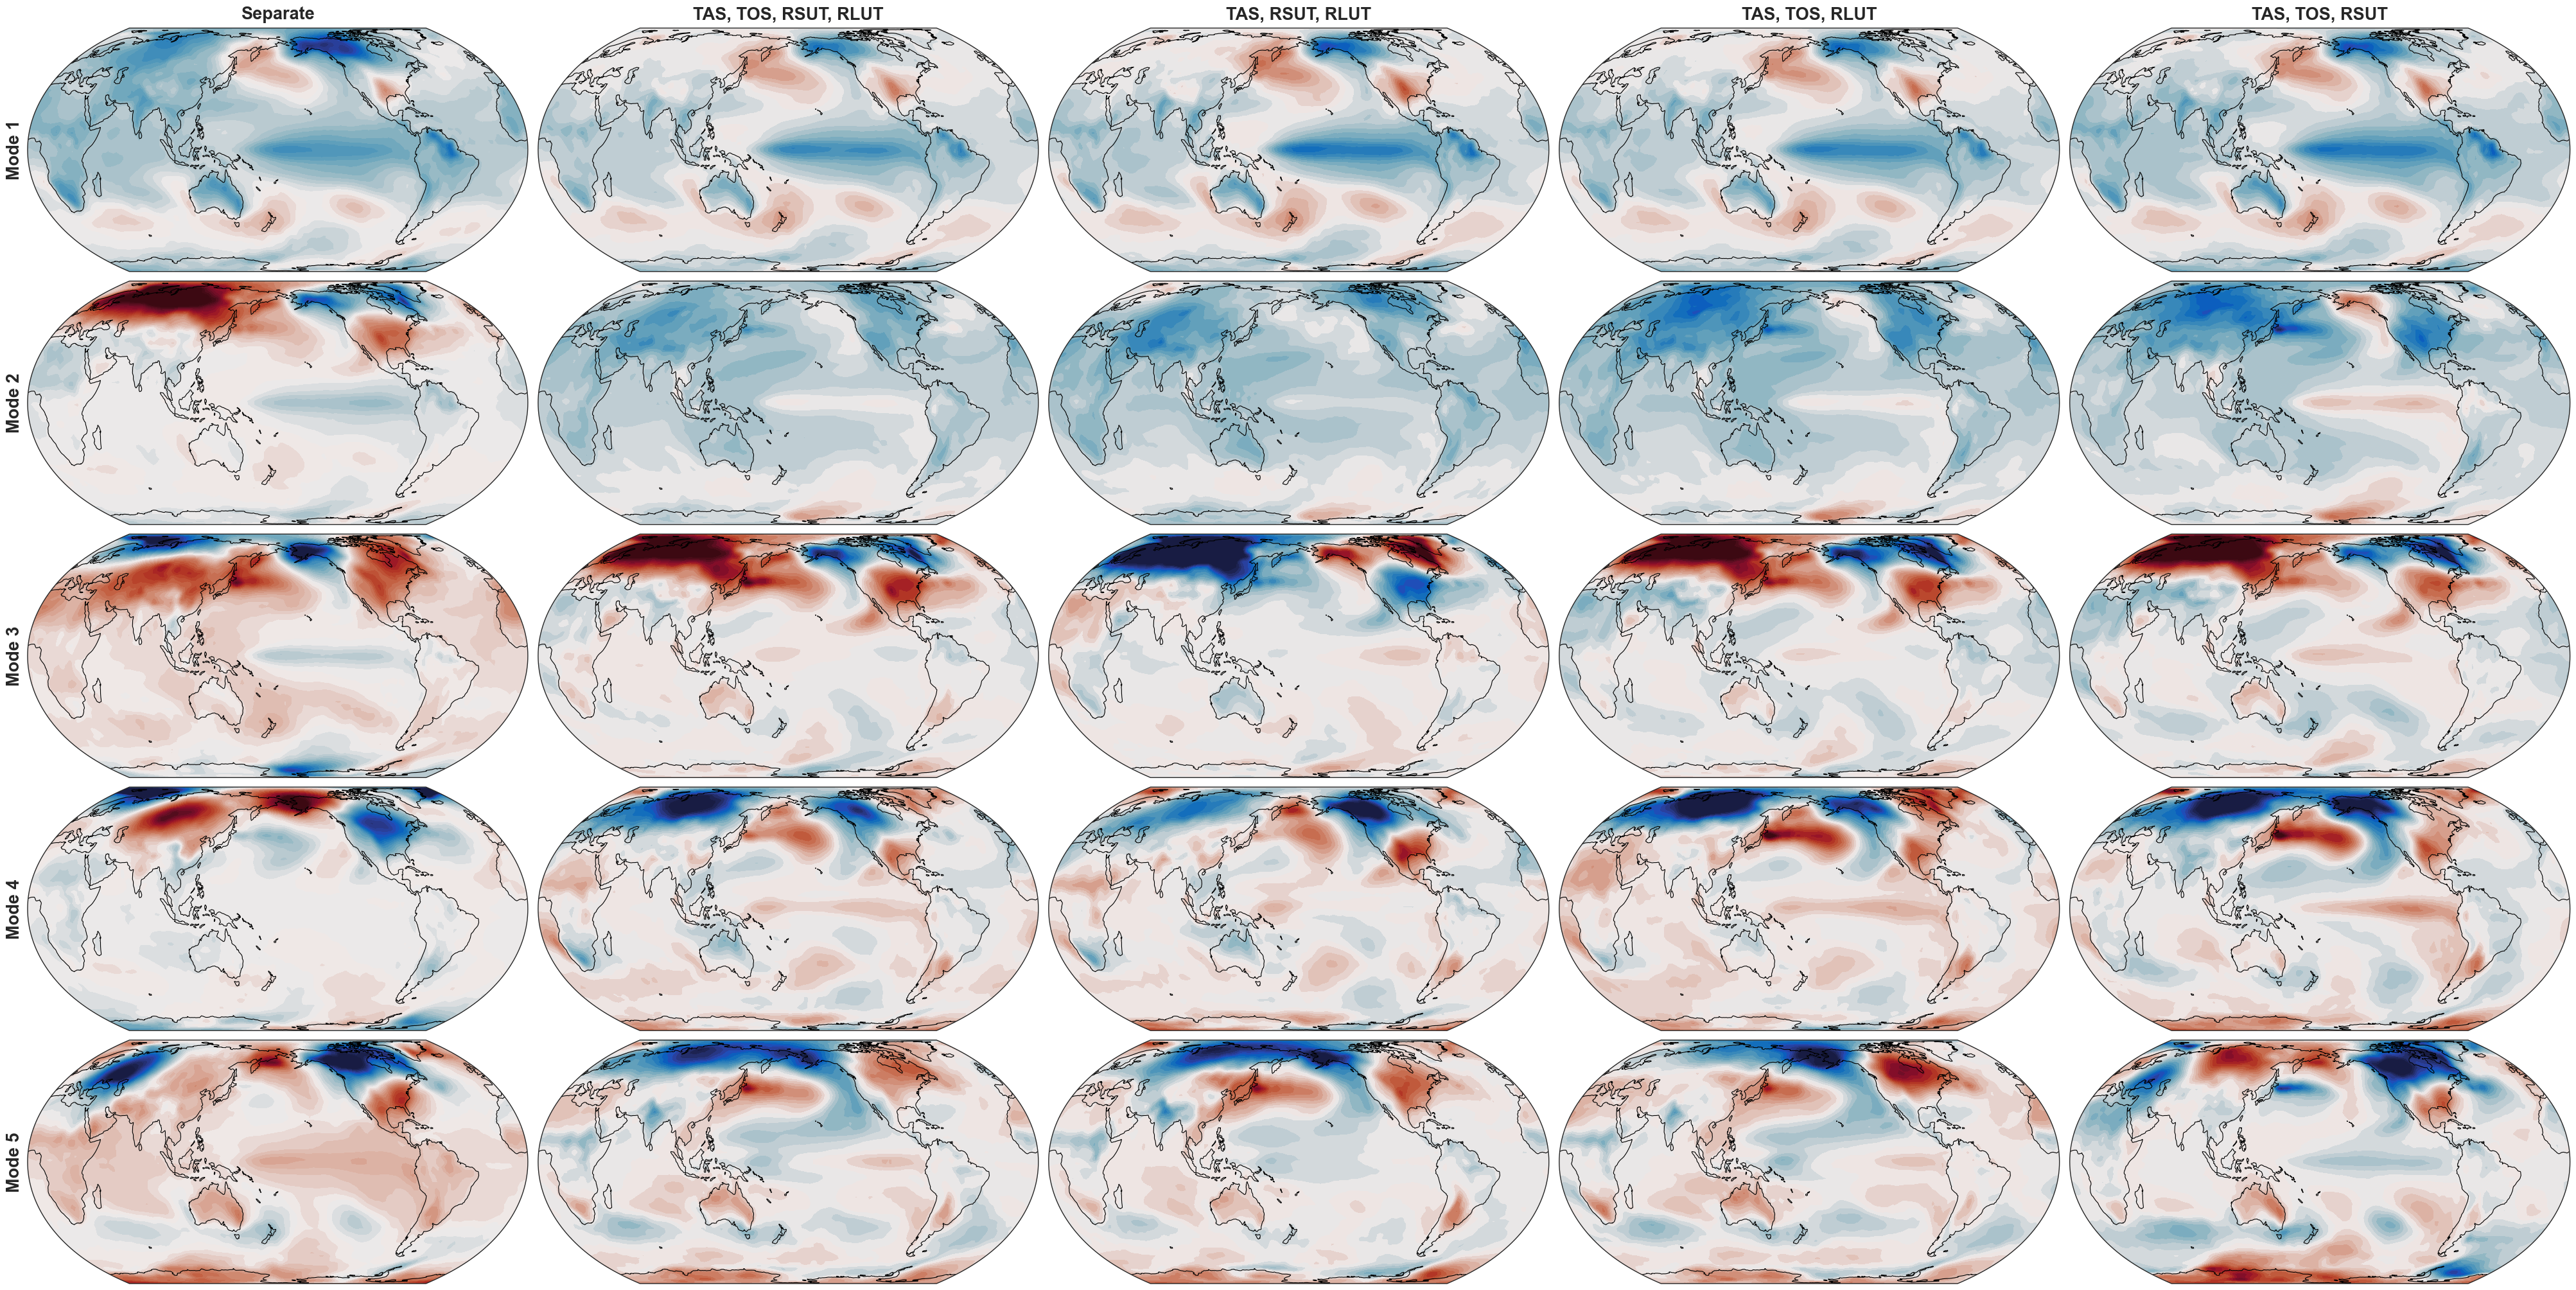

In [117]:
def visualize_tas_eof(
    mappers,
    n_leading=5,
):
    fig, axs = plt.subplots(
        n_leading,
        len(mappers),
        figsize=(len(mappers) * 8, 4 * n_leading),
        subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=180)),
        dpi=100
    )

    tas_eofs_ind = []
    tas_eofs_joint = []
    labels = []
    for i in range(n_leading):
        for mapper in mappers:
            if not mapper.direct_fields:
                with logging_disabled():
                    tas_eofs_joint.append(mapper.get_joint_mode(i)["tas"])
                labels.append(", ".join(map(str.upper, mapper.fields)))
            else:
                eof = mapper.get_individual_mode("tas", i)
                tas_eofs_ind.append(eof)
                labels.append("Separate")


    vmax = np.percentile(np.abs(np.vstack(tas_eofs_ind).flatten()), 99)
    plot_field(axs[:, :1].flatten(), tas_eofs_ind, cmap=cmocean.cm.balance, colorbar=False, vmin=-vmax, vmax=vmax, n_level=50)
    vmax = np.percentile(np.abs(np.vstack(tas_eofs_joint).flatten()), 99)
    plot_field(axs[:, 1:].flatten(), tas_eofs_joint, cmap=cmocean.cm.balance, colorbar=False, vmin=-vmax, vmax=vmax, n_level=50)

    for ax in axs.flat:
        ax.coastlines()
        
    add_subplot_headers([f"Mode {i+1}" for i in range(n_leading)],labels)

visualize_tas_eof(
    [mapper_ind, mapper_joint_all, mappers_leave_one_out["tos"], mappers_leave_one_out["rsut"], mappers_leave_one_out["rlut"]],
)

In [57]:
def get_gistemp_pcs(mapper):
    ds_full = unstack_state(
        xr.DataArray(
            0, dims=("state", "time"), coords=dict(state=mapper.state_coords, time=ds_gistemp.time)
        )
    )
    for field in ds_gistemp.variables:
        ds_full[field] = ds_gistemp[field]
    da_full = to_math_order(stack_state(ds_full))
    with logging_disabled():
        return mapper.forward(da_full.fillna(0)).compute()

In [59]:
xr.corr(get_gistemp_pcs(mapper_joint_all), area_weighted_mean(ds_gistemp["tas"]), "time")

<xarray.DataArray (state: 80)> Size: 640B
array([-0.85689226, -0.99069005,  0.69930935, -0.8406295 , -0.8037243 ,
       -0.83380842, -0.3329486 ,  0.48212548,  0.41819251, -0.080913  ,
       -0.71302523, -0.76859928,  0.7208858 ,  0.25225962, -0.15832414,
       -0.88202526, -0.7135217 , -0.0393963 , -0.42266536, -0.47090455,
       -0.40189171, -0.09226116,  0.39370049, -0.02675568,  0.32320962,
       -0.73808583, -0.22454715, -0.73925869,  0.79554333,  0.36812052,
       -0.02181262,  0.10249692, -0.11785299,  0.37018088, -0.05522112,
       -0.05130165,  0.74806495, -0.7723942 , -0.30350548,  0.01233142,
       -0.600953  ,  0.33351696, -0.51845428,  0.08576935, -0.67513765,
        0.59803273, -0.62928758,  0.61999836, -0.37551639, -0.49418844,
       -0.71218362, -0.03237154, -0.73797363,  0.5698026 , -0.4472242 ,
        0.75057999,  0.09289094, -0.2492361 , -0.17142365,  0.6620767 ,
        0.80981014,  0.44060103, -0.07355667, -0.3754673 , -0.7437832 ,
        0.17667911,  0.1653656 , -0.26654058, -0.70005788,  0.53139169,
        0.30103054,  0.50619747, -0.59554467, -0.0437172 ,  0.14784906,
       -0.06239988, -0.4917031 , -0.47306003, -0.38354496,  0.14366674])
Coordinates:
  * state    (state) int64 640B 0 1 2 3 4 5 6 7 8 ... 71 72 73 74 75 76 77 78 79

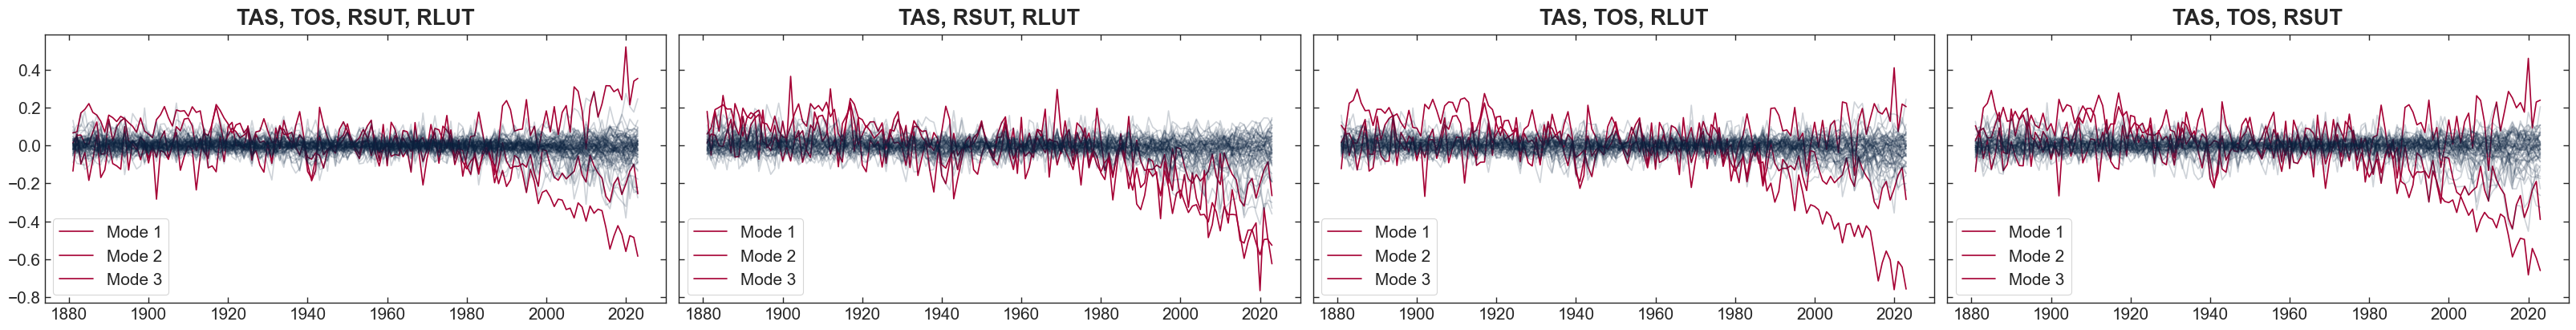

In [60]:
def visualize_joint_pcs(
    mappers,
):
    fig, axs = plt.subplots(
        1,
        len(mappers),
        figsize=(len(mappers) * 8, 4),
        dpi=100,
        sharey=True
    )

    for ax, mapper in zip(axs, mappers):
        i_to_mark = [0, 1, 2]
        da_pcs = get_gistemp_pcs(mapper)
        for i in list(range(len(da_pcs.state))):
            ax.plot(da_pcs.time, da_pcs.isel(state=i),
                    alpha=1 if i in i_to_mark else 0.2,
                    color="C1" if i in i_to_mark else "C0",
                    label=f"Mode {i+1}" if i in i_to_mark else None)
        ax.legend()

    add_subplot_headers(None, [", ".join(map(str.upper, mapper.fields)) for mapper in mappers])

visualize_joint_pcs(
    [mapper_joint_all, mappers_leave_one_out["tos"], mappers_leave_one_out["rsut"], mappers_leave_one_out["rlut"]],
)